Step 1: Load and Explore Data

In [31]:
import pandas as pd

# Load training and test datasets
train_data = pd.read_csv('training.csv')
test_data = pd.read_csv('test.csv')

# Display basic information about the dataset
print(train_data.info())
print(train_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

In [32]:
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48707 entries, 0 to 48706
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              48707 non-null  int64  
 1   PurchDate                          48707 non-null  object 
 2   Auction                            48707 non-null  object 
 3   VehYear                            48707 non-null  int64  
 4   VehicleAge                         48707 non-null  int64  
 5   Make                               48707 non-null  object 
 6   Model                              48707 non-null  object 
 7   Trim                               47157 non-null  object 
 8   SubModel                           48702 non-null  object 
 9   Color                              48703 non-null  object 
 10  Transmission                       48704 non-null  object 
 11  WheelTypeID                        46519 non-null  flo

Step 2: Preprocess Data

We will be using a transformation pipeline for numeric features, it is using StandardScaler. This will standardize numeric features by removing the mean and scaling to unit variance. This is done to each column independently.

For categorical features, we will be using OneHotEncoder so that the variables are in a format that can be provided to machine learning algorithms to improve predictions.

ColumnTransformer will let us apply different transformers to different subsets of columns in the dataset.

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Separate target variable from training data
y_train = train_data['IsBadBuy'].ravel()
X_train = train_data.drop('IsBadBuy', axis=1)
X_test = test_data.copy()

# Combine train and test sets for preprocessing
combined_data = pd.concat([X_train, X_test], axis=0)

# Define numeric and categorical features
numeric_features = combined_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = combined_data.select_dtypes(include=['object']).columns

# Exclude the target variable from categorical features
categorical_features = [col for col in categorical_features if col != 'IsBadBuy']

# Convert the entire categorical column to strings
combined_data[categorical_features] = combined_data[categorical_features].astype(str)

# Create transformers for numeric and categorical features with missing values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Custom transformer using LabelEncoder
def label_encode_column(series):
    le = LabelEncoder()
    return le.fit_transform(series).reshape(-1, 1)

label_encoded_cols = []
for col in categorical_features:
    label_encoded_cols.append((col, FunctionTransformer(label_encode_column, validate=False), [col]))

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        *label_encoded_cols
    ])

# Fit and preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


C:\Users\js774\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\js774\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\js774\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\js774\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

In [34]:
X_train_preprocessed.shape

(72983, 33)

Making sure that there are no more null values in the data

Step 3: Train Model with Hyperparameter Tuning (GridSearchCV)

We are using Random Forest Classifier first.

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
model = RandomForestClassifier()

# Define the hyperparameter grid including the step name (classifier) and parameter names
param_grid = {
    'classifier__n_estimators': [3, 5, 50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    # Add other hyperparameters as needed
}

# Create a pipeline with the classifier
pipeline = Pipeline(steps=[('classifier', model)])

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train_preprocessed, y_train)

# Print the best hyperparameters from GridSearch
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END classifier__max_depth=None, classifier__n_estimators=3; total time=   2.4s
[CV] END classifier__max_depth=None, classifier__n_estimators=3; total time=   2.3s
[CV] END classifier__max_depth=None, classifier__n_estimators=3; total time=   2.3s
[CV] END classifier__max_depth=None, classifier__n_estimators=5; total time=   3.9s
[CV] END classifier__max_depth=None, classifier__n_estimators=5; total time=   3.7s
[CV] END classifier__max_depth=None, classifier__n_estimators=5; total time=   4.2s
[CV] END classifier__max_depth=None, classifier__n_estimators=50; total time=  42.7s
[CV] END classifier__max_depth=None, classifier__n_estimators=50; total time=  43.5s
[CV] END classifier__max_depth=None, classifier__n_estimators=50; total time=  45.8s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time= 1.5min
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time= 1.5min
[CV] END

In [36]:
import joblib

# Save the best model to a file
best_model_filename = 'best_model.joblib'
joblib.dump(grid_search.best_estimator_, best_model_filename)


['best_model.joblib']

In [37]:
import pandas as pd

cv_results_df = pd.DataFrame(grid_search.cv_results_)
print(cv_results_df)


    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.364320      0.039000         0.040700        0.011191   
1        3.977830      0.217561         0.064127        0.012643   
2       43.493040      1.443466         0.603533        0.162150   
3       88.446139      2.181317         1.240487        0.374132   
4      167.695512      5.253592         2.364642        0.749383   
5        1.023928      0.095479         0.024906        0.003770   
6        1.629653      0.058726         0.032855        0.009701   
7       16.055010      0.372246         0.281642        0.035453   
8       34.544299      0.709255         0.648730        0.081634   
9       72.400829      1.390678         1.340331        0.189415   
10       2.047769      0.026557         0.039433        0.011356   
11       3.349103      0.063473         0.059517        0.015008   
12      37.153526      3.286637         0.535212        0.093473   
13      83.845909      0.638788         1.191085

Mean accuracy of the best parameters was 80.6528%
It's std test score was 0.110265 which is considered low. This indicates relatively stable performance.

Using SHAP to find the least important variables, that will be removed.
We will then run the model again and see if it gets better with the least important variables.

In [41]:
preprocessor.fit(X_train)
print(preprocessor.named_transformers_.keys())


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

dict_keys(['num', 'PurchDate', 'Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST'])


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

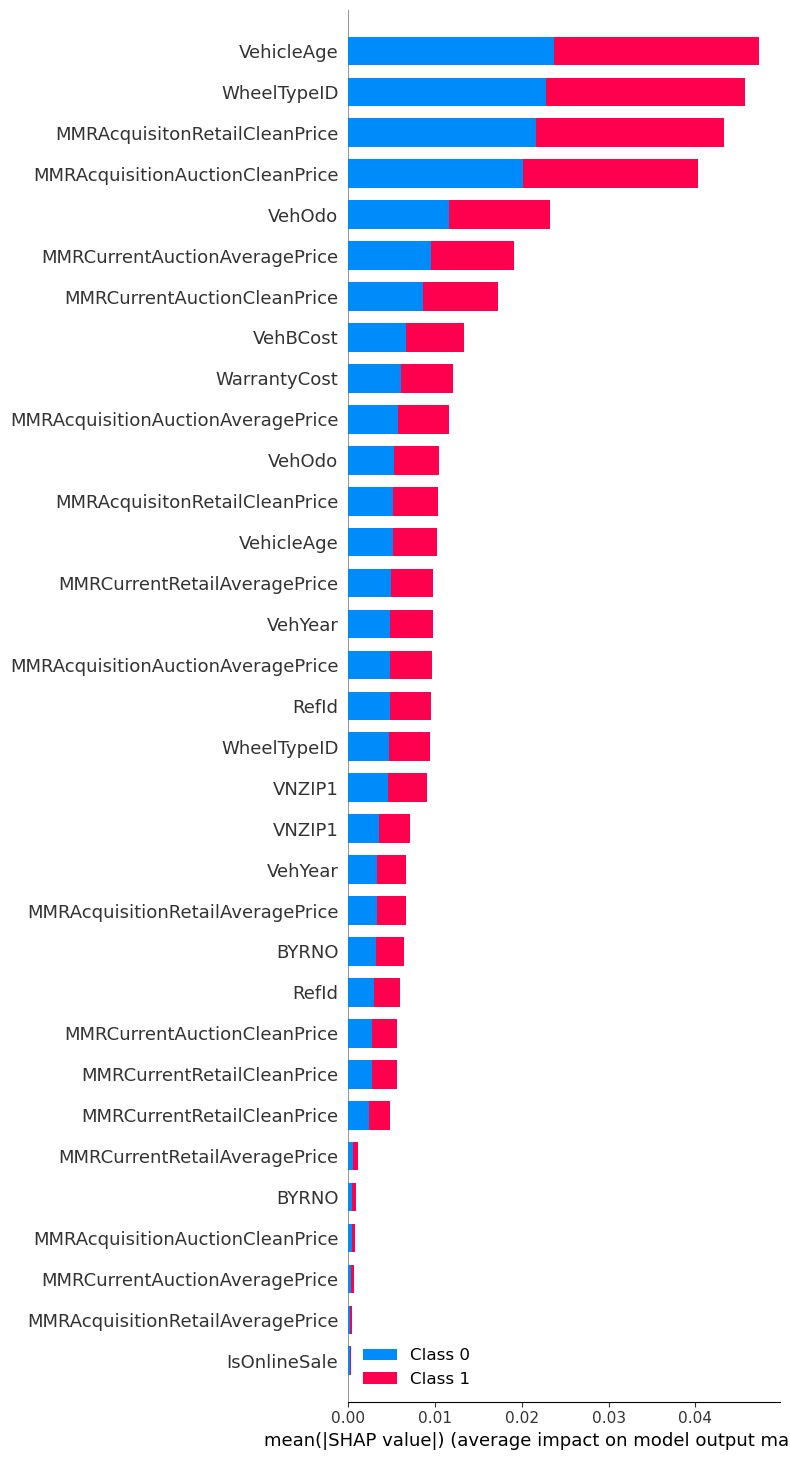

100%|███████████████████████████████████████████████████████████████████████████| 72983/72983 [02:02<00:00, 593.66it/s]


In [43]:
import shap
from tqdm import tqdm

best_model = grid_search.best_estimator_

# Extract the RandomForestClassifier from the pipeline
random_forest = best_model.named_steps['classifier']

# Create a SHAP explainer for the RandomForestClassifier
explainer = shap.TreeExplainer(random_forest)

# Assuming preprocessor is your ColumnTransformer
preprocessor.fit(X_train)

# Replace 'num' with the key associated with your numeric transformer
numeric_transformer_key = 'num'
feature_names_numeric = preprocessor.named_transformers_[numeric_transformer_key] \
                         .named_steps['scaler'] \
                         .get_feature_names_out(numeric_features)

# Combine numeric and categorical feature names
all_feature_names = numeric_features.tolist() + feature_names_numeric.tolist()

# Transform the preprocessed training data to a numpy array
X_train_numpy = preprocessor.transform(X_train)

# Calculate SHAP values with aggregation
shap_values = explainer.shap_values(X_train_numpy, approximate=True, check_additivity=False)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_train_numpy, feature_names=all_feature_names, max_display=34)

# If you want to show a progress bar, you can wrap your loop with tqdm
for i in tqdm(range(len(X_train_numpy))):
    _ = explainer.shap_values(X_train_numpy[i, :])


In [47]:
X_train_preprocessed.shape

(72983, 33)

In [49]:
import numpy as np

# Define the list of features to remove
features_to_remove = ['MMRCurrentRetailAveragePrice', 'BYRNO', 'MMRAcquisitionAuctionCleanPrice',
                       'MMRCurrentAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice', 'IsOnlineSale']

# Get the indices of the columns to keep
columns_to_keep = np.array([col for col in range(X_train_preprocessed.shape[1]) if col not in features_to_remove])

# Remove the specified features from X_train_preprocessed and X_test_preprocessed
X_train_preprocessed_filtered = X_train_preprocessed[:, columns_to_keep]
X_test_preprocessed_filtered = X_test_preprocessed[:, columns_to_keep]


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
model = RandomForestClassifier()

# Define the hyperparameter grid including the step name (classifier) and parameter names
param_grid = {
    'classifier__n_estimators': [3, 5, 50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    # Add other hyperparameters as needed
}

# Create a pipeline with the classifier
pipeline = Pipeline(steps=[('classifier', model)])

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train_preprocessed_filtered, y_train)

# Print the best hyperparameters from GridSearch
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END classifier__max_depth=None, classifier__n_estimators=3; total time=   2.3s
[CV] END classifier__max_depth=None, classifier__n_estimators=3; total time=   2.4s
[CV] END classifier__max_depth=None, classifier__n_estimators=3; total time=   2.4s
[CV] END classifier__max_depth=None, classifier__n_estimators=5; total time=   3.8s
[CV] END classifier__max_depth=None, classifier__n_estimators=5; total time=   4.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=5; total time=   3.9s
[CV] END classifier__max_depth=None, classifier__n_estimators=50; total time=  38.4s
[CV] END classifier__max_depth=None, classifier__n_estimators=50; total time=  39.6s
[CV] END classifier__max_depth=None, classifier__n_estimators=50; total time=  41.3s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time= 1.3min
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time= 1.3min
[CV] END

In [51]:
import joblib

# Save the best model to a file
best_model2_filename = 'best_model_removal.joblib'
joblib.dump(grid_search.best_estimator_, best_model2_filename)

['best_model_removal.joblib']

In [52]:
import pandas as pd

cv_results_df = pd.DataFrame(grid_search.cv_results_)
print(cv_results_df)


    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.448334      0.042428         0.037143        0.014221   
1        3.965811      0.119679         0.073190        0.007321   
2       39.304806      1.276127         0.559550        0.150082   
3       79.200157      2.064198         1.085745        0.294212   
4      195.956010     29.705826         2.562802        0.883730   
5        1.579255      0.029660         0.031711        0.000284   
6        2.657654      0.053188         0.062560        0.000022   
7       26.208423      0.212580         0.444846        0.070180   
8       51.918530      0.621508         0.895132        0.148311   
9      104.557527      0.891483         1.731760        0.293038   
10       3.026155      0.064785         0.057334        0.019541   
11       4.965341      0.024360         0.074231        0.019976   
12      49.219357      0.487213         0.651154        0.175589   
13      98.254686      1.300376         1.282224